In [1]:
import torch as t
from torch.autograd import Variable
t.set_grad_enabled(True)
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os.path
from os import path

shap.initjs()

In [2]:
from src.caseDataset import CaseDataset
from src.neuralNetwork import *

In [3]:
caseType = 3
txtSubname = 'contiAge001'
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
A, B, C, D = coef[0], coef[1], coef[2], coef[3]
totalData

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,-0.92,-1.0,1.0,115.0,-105.0,112.040010,-108.237789,-108.8,-138.8,-104.260130,-140.967104,-108.8,36.0,-110.884371,30.903047
1,-1.0,0.48,1.0,1.0,-105.0,115.0,-106.879361,116.286714,57.2,87.2,53.461226,90.748609,-34.0,87.2,-35.642870,82.665815
2,-1.0,0.04,1.0,-1.0,75.0,-85.0,74.052244,-84.644700,-22.0,8.0,-25.346215,11.366214,-22.0,15.6,-23.603358,12.001047
3,1.0,-0.88,-1.0,-1.0,-85.0,75.0,-82.993870,87.191321,54.0,24.0,44.554073,22.917291,-113.2,24.0,-105.024805,31.829598
4,-1.0,0.48,1.0,-1.0,75.0,-85.0,73.324002,-83.807528,-44.0,-14.0,-48.902361,-14.328907,-44.0,77.2,-42.046240,80.655396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,-1.00,-1.0,1.0,115.0,-105.0,118.519213,-109.426492,-120.0,-150.0,-119.067786,-147.635503,-120.0,40.0,-123.034190,34.374009
996,1.0,-0.76,-1.0,-1.0,-85.0,75.0,-85.577661,74.330939,48.0,18.0,46.021282,20.169814,-96.4,18.0,-97.628791,11.250763
997,-1.0,0.32,1.0,1.0,-105.0,115.0,-102.230083,114.539388,34.8,64.8,35.821692,61.666962,-26.0,64.8,-26.790577,63.975273
998,-1.0,0.08,1.0,1.0,-105.0,115.0,-105.411036,114.494782,1.2,31.2,-3.440703,32.867533,-14.0,31.2,-13.550583,24.036370


In [4]:
totalCaseData = CaseDataset(totalData, caseType=caseType)

## Loading model

In [5]:
PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
model = NeuralNetwork()
model.load_state_dict(t.load(PATH))
model.eval()

NeuralNetwork(
  (linearLayer): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
print(totalCaseData.feature)

[[ 1.    1.   -0.92]
 [-1.    1.    0.48]
 [-1.   -1.    0.04]
 ...
 [-1.    1.    0.32]
 [-1.    1.    0.08]
 [ 1.    1.   -0.76]]


In [7]:
# explain predictions of the model on four images
e = shap.DeepExplainer(model, Variable(t.from_numpy(totalCaseData.feature).float()))

In [8]:
if path.isfile('shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname)):
    shap_values = np.load('shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname))
    print('load from shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname))
else:
    print('evaluate SHAP value')
    shap_values = e.shap_values(Variable(t.from_numpy(totalCaseData.feature).float()))
print(shap_values.shape)

evaluate SHAP value


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


(1000, 3)


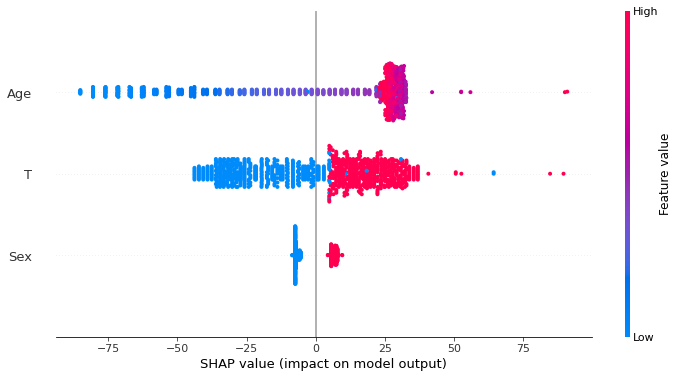

In [9]:
shap.summary_plot(shap_values, totalCaseData.feature, ['T', 'Sex', 'Age'], plot_size=(12, 6))

In [10]:
features = pd.DataFrame(totalCaseData.feature)
features = features.rename(columns={0:'T', 1:'Sex', 2:'Age'})
features

,T,Sex,Age
0,1.0,1.0,-0.92
1,-1.0,1.0,0.48
2,-1.0,-1.0,0.04
3,1.0,-1.0,-0.88
4,-1.0,-1.0,0.48
...,...,...,...
995,1.0,1.0,-1.00
996,1.0,-1.0,-0.76
997,-1.0,1.0,0.32
998,-1.0,1.0,0.08


In [11]:
def dependence_plot(idx, features, shap_values, cbarIdx=None, featureName=None, title=None):
    columnName = list(features.columns)
    norm=plt.Normalize(-1,1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#1e88e5", "#f52757"])
    fig = plt.figure(figsize=(10, 8))
    if not isinstance(cbarIdx, int):
        cbarIdx = idx
    plt.scatter(features.iloc[:, idx], shap_values[:, idx], c=features.iloc[:, cbarIdx], cmap=cmap, s=50)
    cbar = plt.colorbar()
    cbar.set_label('{}'.format(columnName[cbarIdx]), rotation=270, fontsize=20, labelpad=20)
    cbarMin, cbarMax = np.min(features.iloc[:, cbarIdx]), np.max(features.iloc[:, cbarIdx])
    cbar.set_ticks(np.linspace(cbarMin, cbarMax, 5))
    cbar.ax.tick_params(labelsize=20) 
    plt.xlabel("{}".format(featureName), fontsize=20)
    plt.ylabel("SHAP value for {}".format(featureName), fontsize=20)
    plt.xticks(np.linspace(np.min(features.iloc[:, idx]), np.max(features.iloc[:, idx]), 3), fontsize=20)
    plt.yticks(fontsize=20)
    amplitude = np.max(shap_values) * np.max(shap_values)
    plt.ylim(np.min(shap_values) - amplitude / 2 * 0.01, np.max(shap_values) + amplitude / 2 * 0.01)
    if title:
        plt.title(title, fontsize=25)

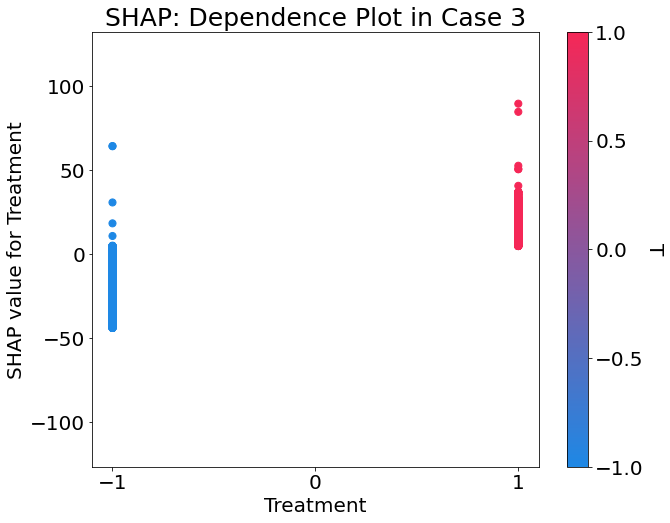

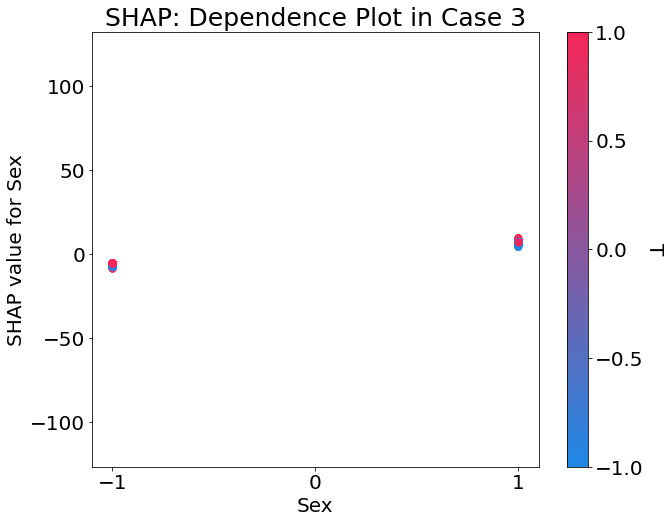

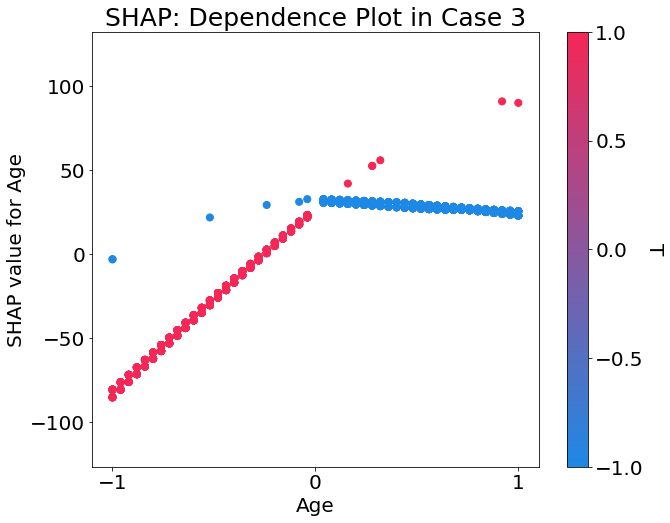

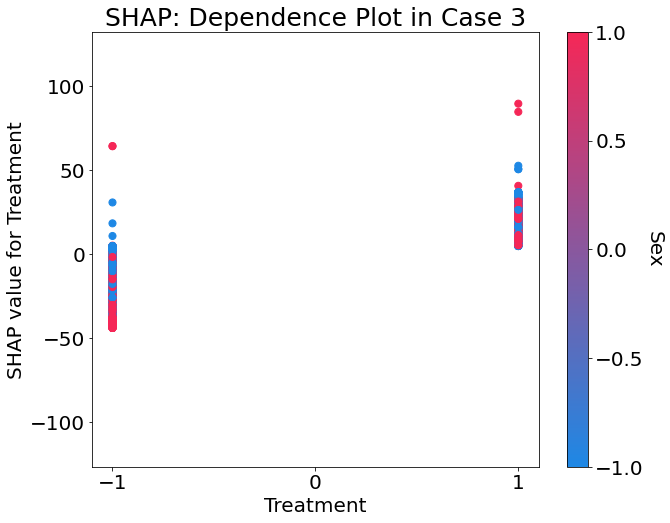

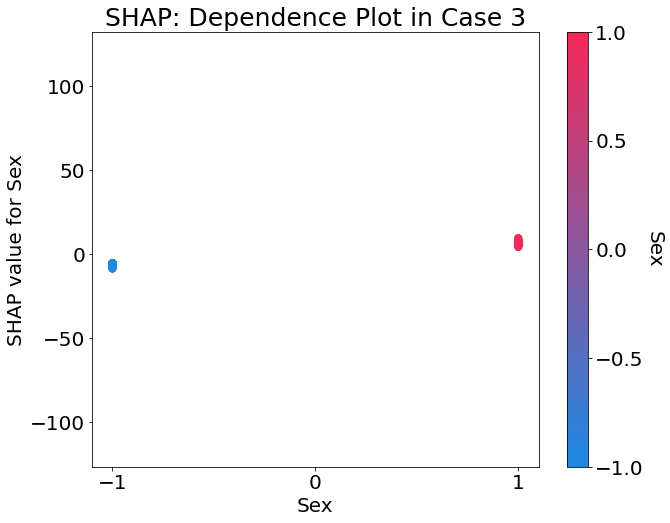

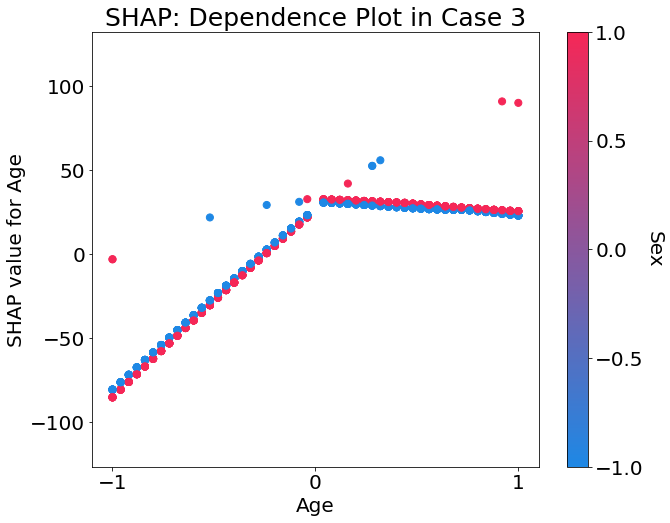

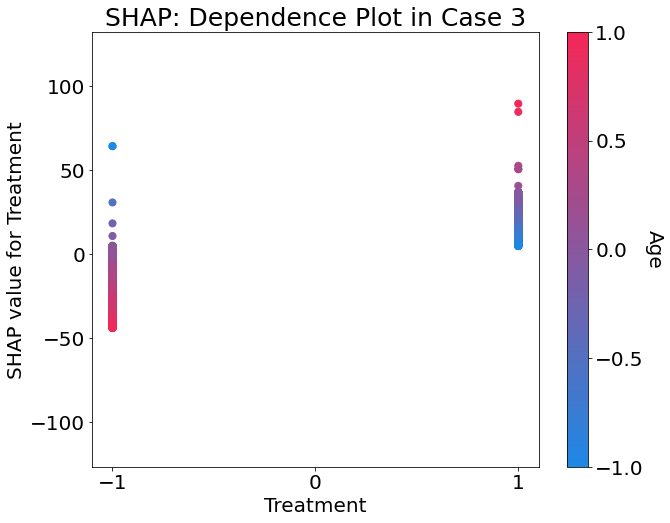

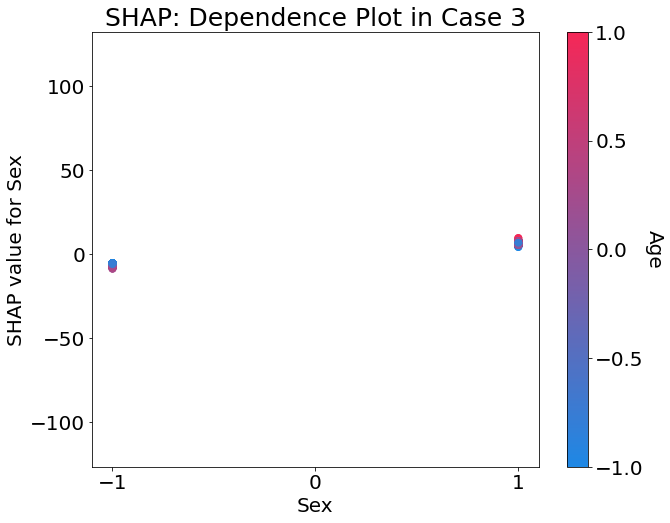

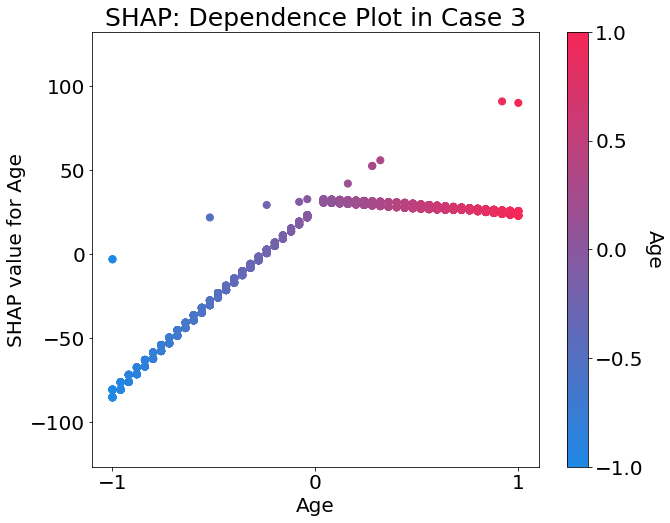

In [12]:
title = "SHAP: Dependence Plot in Case {}".format(caseType)
for cbarIdx in range(0, 3):
    dependence_plot(0, features, shap_values, cbarIdx=cbarIdx, featureName='Treatment', title=title)
    dependence_plot(1, features, shap_values, cbarIdx=cbarIdx, featureName='Sex', title=title)
    dependence_plot(2, features, shap_values, cbarIdx=cbarIdx, featureName='Age', title=title)

In [13]:
np.save('shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname), shap_values)